חלק א': הכנת הנתונים והבנת הנתונים של טבלת המכירות

ייבוא וארגון הדאטה בפייתון

1.import the csv files 

In [186]:
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Paths to your CSV files
file1 = './Products.csv'
file2 = './Transactions.csv'

2.read the csv

In [187]:
# Read the CSV files
Products = pd.read_csv(file1)
Transactions = pd.read_csv(file2)

הבנת מבנה הנתונים:


1.2.1 - תשובה על סעיף 1 

2.2.1 - תשובה על סעיף 2 

3.2.1 - תשובה על סעיף 3 

איחוד הטבלאות:


1.Merge tables using the Product field


In [188]:

# Merge tables using the Product field
df_transactions = pd.DataFrame(Transactions)
df_Products = pd.DataFrame(Products)
df_transactions.columns = df_transactions.columns.str.strip()
df_Products.columns = df_Products.columns.str.strip()
enriched_data = pd.merge(df_transactions, df_Products, on="Product", how="left")
df = pd.DataFrame(enriched_data)
output_filename = "enriched_data.csv"
df.to_csv(output_filename, index=False)

2.Split the 'Segement_Country' column into 'Segment' and 'Country' and drop the old column

In [189]:
# Split the 'Segement_Country' column into 'Segment' and 'Country'
df[['Segment', 'Country']] = df['Segement_Country'].str.split('-', expand=True)
# Drop the original 'Segement_Country' column if it's no longer needed
df = df.drop(columns=['Segement_Country'])
output_filename = "drop_Segement_Country.csv"
df.to_csv(output_filename, index=False)

בדיקת תקינות:


1,2.checking if the merge was ok

In [190]:
def validate_merge(df_transactions, df_products, merged_df, key_column="Product"):
    # Check if all products in df_transactions exist in df_products
    missing_products = df_transactions[~df_transactions[key_column].isin(df_products[key_column])][key_column].unique()
    
    # Check for any rows where the merge resulted in missing values
    missing_values = merged_df.isnull().sum().sum()  # Count total missing values
    
    # Print or return results
    if len(missing_products) == 0 and missing_values == 0:
        print("Merge successful! No data was lost.")
        return True
    else:
        print(f"Warning: {len(missing_products)} products in transactions were not found in products.")
        if len(missing_products) > 0:
            print("Missing Products:", missing_products)
        print(f"Total missing values after merge: {missing_values}")
        return False

# Usage
is_merge_valid = validate_merge(df_transactions, df_Products, enriched_data)

Total missing values after merge: 53


In [191]:
#Check if no data missing after mergin
print(df.isnull().sum())  # Check for nulls in any column
print(f"Rows in Products DataFrame: {Products.shape[0]}")
print(f"Rows in Transactions DataFrame: {Transactions.shape[0]}")
print(f"Rows in Enriched Data: {df.shape[0]}")
print(df.columns)
print(df['Product'].value_counts())

Product                 0
Discount Band          53
Units Sold              0
Sale Price              0
Gross Sales             0
Discounts               0
Sales                   0
COGS                    0
Profit                  0
Date                    0
Month Number            0
ProductID               0
Category                0
Manufacturing Price     0
Segment                 0
Country                 0
dtype: int64
Rows in Products DataFrame: 6
Rows in Transactions DataFrame: 700
Rows in Enriched Data: 700
Index(['Product', 'Discount Band', 'Units Sold', 'Sale Price', 'Gross Sales',
       'Discounts', 'Sales', 'COGS', 'Profit', 'Date', 'Month Number',
       'ProductID', 'Category', 'Manufacturing Price', 'Segment', 'Country'],
      dtype='object')
Product
Paseo        202
Velo         109
VTT          109
Amarilla      94
Carretera     93
Montana       93
Name: count, dtype: int64


3.3.1- תשובה לשאלה 3 

טיפול בנתונים : 


נתונים כספיים


1.deal with the format of the  financial details

In [192]:

# Define a function to clean the financial fields
def clean_financial_field(value):
    if isinstance(value, (int, float)):  # If already a number, return it as is
        return value
    # Remove non-numeric characters (e.g., $, commas, extra dots)
    clean_value = (
        value.replace("$", "")
             .replace(",", "")
             .replace(".", "", value.count(".") - 1)  # Handle decimal points correctly
    )
    try:
        return float(clean_value)  # Convert to a float for analysis
    except ValueError:
        return None  # Return None for non-convertible values
    
# Identify the financial fields that need cleanup
financial_fields = ["Sale Price", "Gross Sales", "Discounts", "Sales", "COGS", "Profit","Manufacturing Price"]

# Apply the cleaning function to each field
for field in financial_fields:
    df[field] = df[field].apply(clean_financial_field)
    
output_filename = "financial_fields.csv"
df.to_csv(output_filename, index=False) 

2.1.2 - תשובה לשאלה 2 

עמודת _Segment_Country:


טיפול בנתוני התאריך


העמודה תאריך בטבלה זו מייצגת את העסקה או את תאריך המכירה שבו התרחשה מכירה מסוימת. הוא מתעד את היום, החודש והשנה המדויקים של המכירה.

2,3.Format Date Column and after it formated i create two more columns ,month_name,and year.
also i print the wrong/unusual dates

In [193]:

# Format Date Column
def validate_and_fix_date(row):
    try:
        # Parse the existing date
        date = pd.to_datetime(row['Date'], format='%m/%d/%Y', errors='coerce')
        
        # Check if the date's month matches the Month Number column
        if date and date.month != row['Month Number']:
            print(date.month , row['Month Number'])
            # Correct the date by aligning it with the Month Number column
            corrected_date = pd.Timestamp(year=date.year, month=row['Month Number'], day=1)
        else:
            corrected_date = date
    except:
        # Handle invalid or unusual dates
        print(row['Date'])
        

    return corrected_date

# Identify unusual or missing dates
df['Date'] = df.apply(validate_and_fix_date, axis=1)

# Format the Corrected Date into a single consistent format
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')
df['Date'] = pd.to_datetime(df['Date'])
df['Year']=df['Date'].dt.year

df["Month Name"] = df["Month Number"].apply(lambda x: calendar.month_name[x])
# df["Year"] = df["Date"].dt.year

output_filename = "add_year_month.csv"
df.to_csv(output_filename, index=False) 

4.2.2 - תשובה לשלאלה 4 

יצירת עמודות מחושבות

1.add to df two columns : Discount Impact,Profit Margin

In [194]:
#create new Discount Impact column
df['Discount Impact'] = df['Discounts'] / df['Sales']
df['Profit Margin'] = (df['Profit'] / df['Sales']) * 100
output_filename = "create_two_new_columns.csv"
df.to_csv(output_filename, index=False)

תחילת חלק ב׳ של העבודה - סעיף ראשון

סעיף 1 שאלה 1

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_5876/2800536369.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




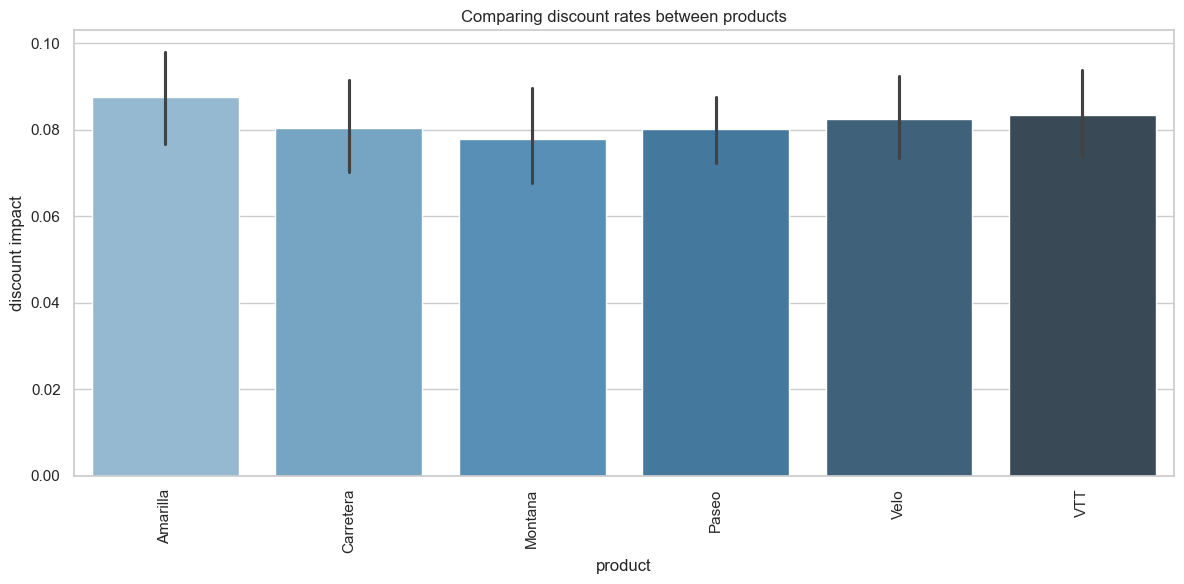

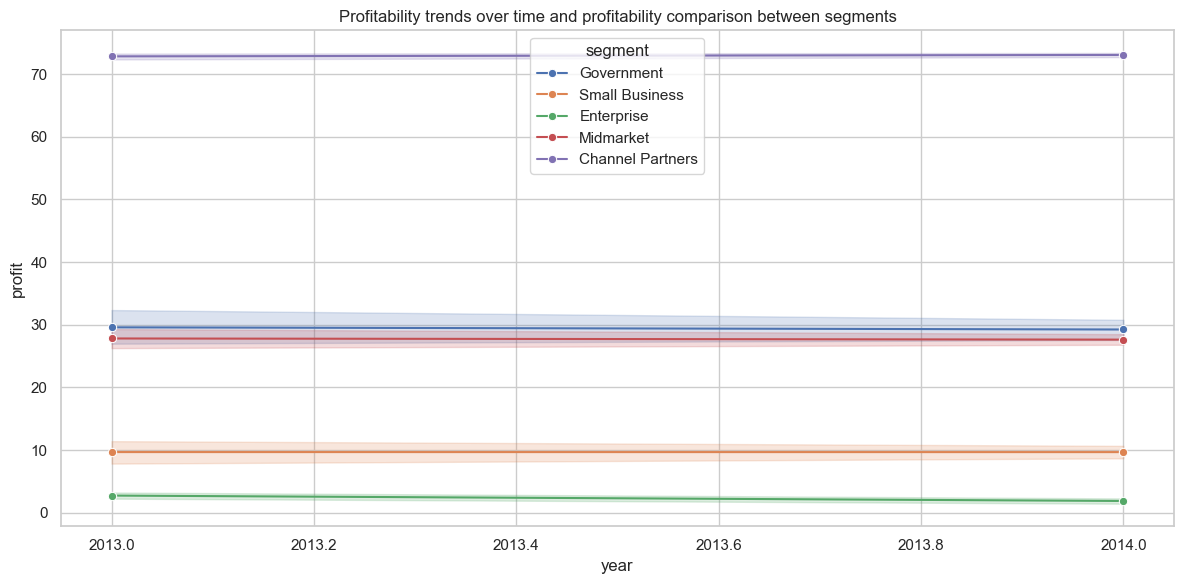

In [195]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Product', y='Discount Impact', data=df, palette="Blues_d")
plt.title('Comparing discount rates between products')
plt.xlabel('product')
plt.ylabel('discount impact')
plt.xticks(rotation=90)  # לסובב את שמות המוצרים אם יש הרבה מוצרים
plt.tight_layout()
plt.show()

# גרף להצגת מגמות הרווחיות לאורך זמן תוך השוואת רווחיות בין סגמנטים
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Profit Margin', hue='Segment', data=df, marker='o')
plt.title('Profitability trends over time and profitability comparison between segments')
plt.xlabel('year')
plt.ylabel('profit')
plt.legend(title='segment')
plt.tight_layout()
plt.show()

סעיף 1 שאלה 2

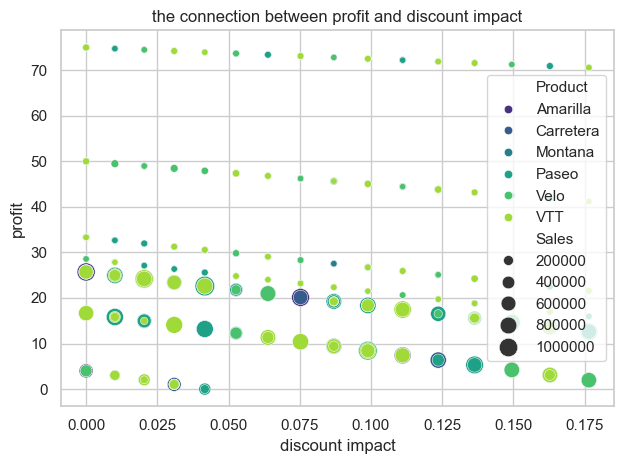

In [196]:
sns.scatterplot(
    x='Discount Impact', 
    y='Profit Margin', 
    hue='Product',  
    size='Sales',  # שינוי גודל הנקודות לפי מכירות
    sizes=(20, 200), 
    data=df, 
    palette="viridis",  
    legend=True
)

plt.title('the connection between profit and discount impact')
plt.xlabel('discount impact')
plt.ylabel('profit')
plt.tight_layout()
plt.show()

 מגמות רווחיות ומכירות לפי שנה:

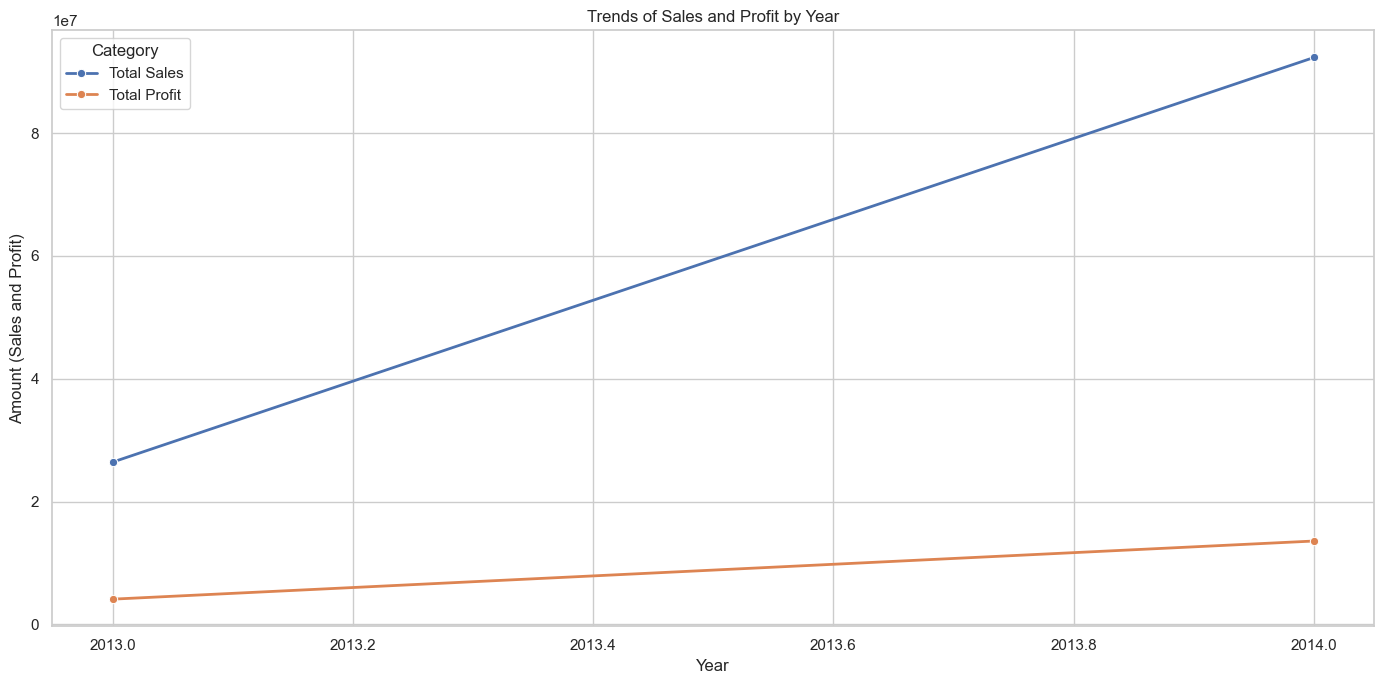

In [197]:
# ניתוח מגמות מכירות ורווחיות לפי שנה
annual_trends = df.groupby('Year').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Discount_Impact=('Discount Impact', 'mean'),
    Avg_Profit_Margin=('Profit Margin', 'mean')
).reset_index()

# גרף משולב עם מכירות ורווחיות לאורך השנים
plt.figure(figsize=(14, 7))

# גרף קווים למכירות (Total Sales)
sns.lineplot(data=annual_trends, x='Year', y='Total_Sales', label='Total Sales', marker='o', linewidth=2)

# גרף קווים לרווחיות (Total Profit)
sns.lineplot(data=annual_trends, x='Year', y='Total_Profit', label='Total Profit', marker='o', linewidth=2)

# הוספת כותרת ותגיות
plt.title('Trends of Sales and Profit by Year')
plt.xlabel('Year')
plt.ylabel('Amount (Sales and Profit)')
plt.legend(title='Category', loc='upper left')

# הצגת הגרף
plt.tight_layout()
plt.show()


2. מגמות מכירות ורווחיות לפי חודש:

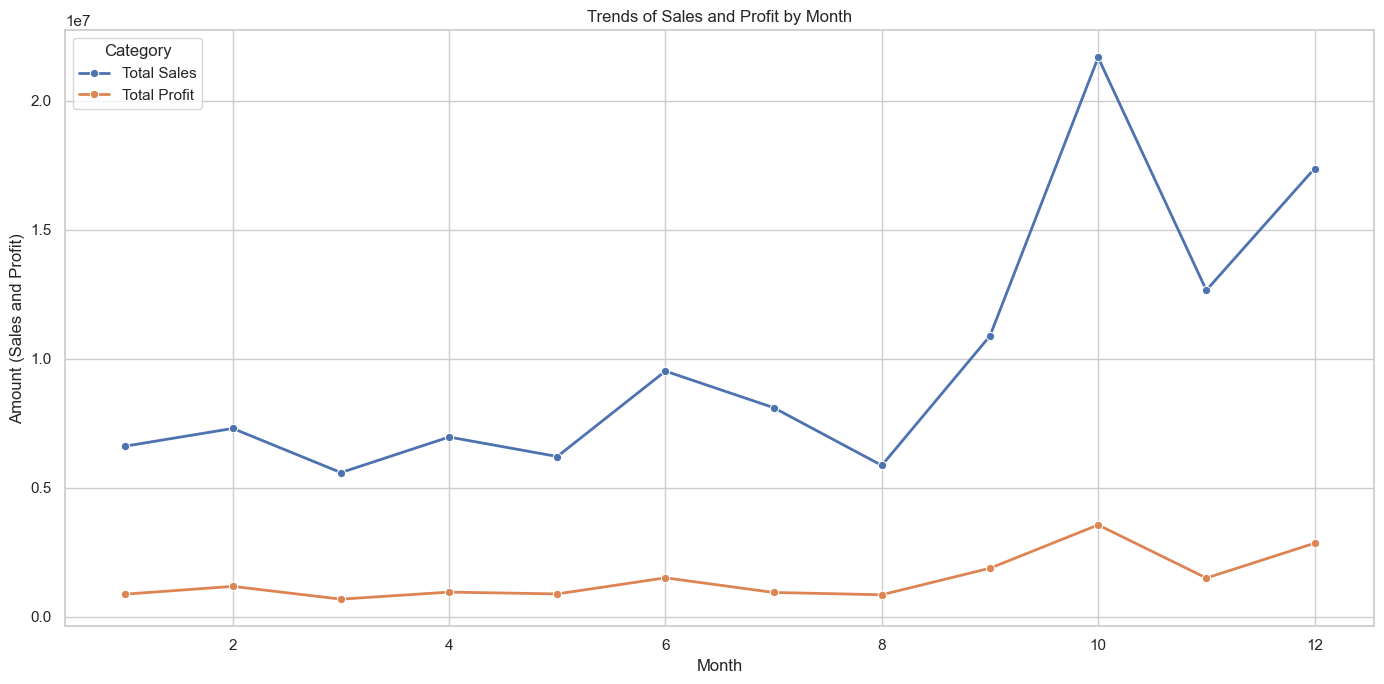

In [198]:
# ניתוח מגמות מכירות ורווחיות לפי חודש
monthly_trends = df.groupby('Month Number').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Discount_Impact=('Discount Impact', 'mean'),
    Avg_Profit_Margin=('Profit Margin', 'mean')
).reset_index()

# גרף משולב עם מכירות ורווחיות לאורך חודשים
plt.figure(figsize=(14, 7))

# גרף קווים למכירות (Total Sales)
sns.lineplot(data=monthly_trends, x='Month Number', y='Total_Sales', label='Total Sales', marker='o', linewidth=2)

# גרף קווים לרווחיות (Total Profit)
sns.lineplot(data=monthly_trends, x='Month Number', y='Total_Profit', label='Total Profit', marker='o', linewidth=2)

# הוספת כותרת ותגיות
plt.title('Trends of Sales and Profit by Month')
plt.xlabel('Month')
plt.ylabel('Amount (Sales and Profit)')
plt.legend(title='Category', loc='upper left')

# הצגת הגרף
plt.tight_layout()
plt.show()


3. השוואת רווחיות ומכירות בין סגמנטים (Segment):

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_5876/3694917760.py:8: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




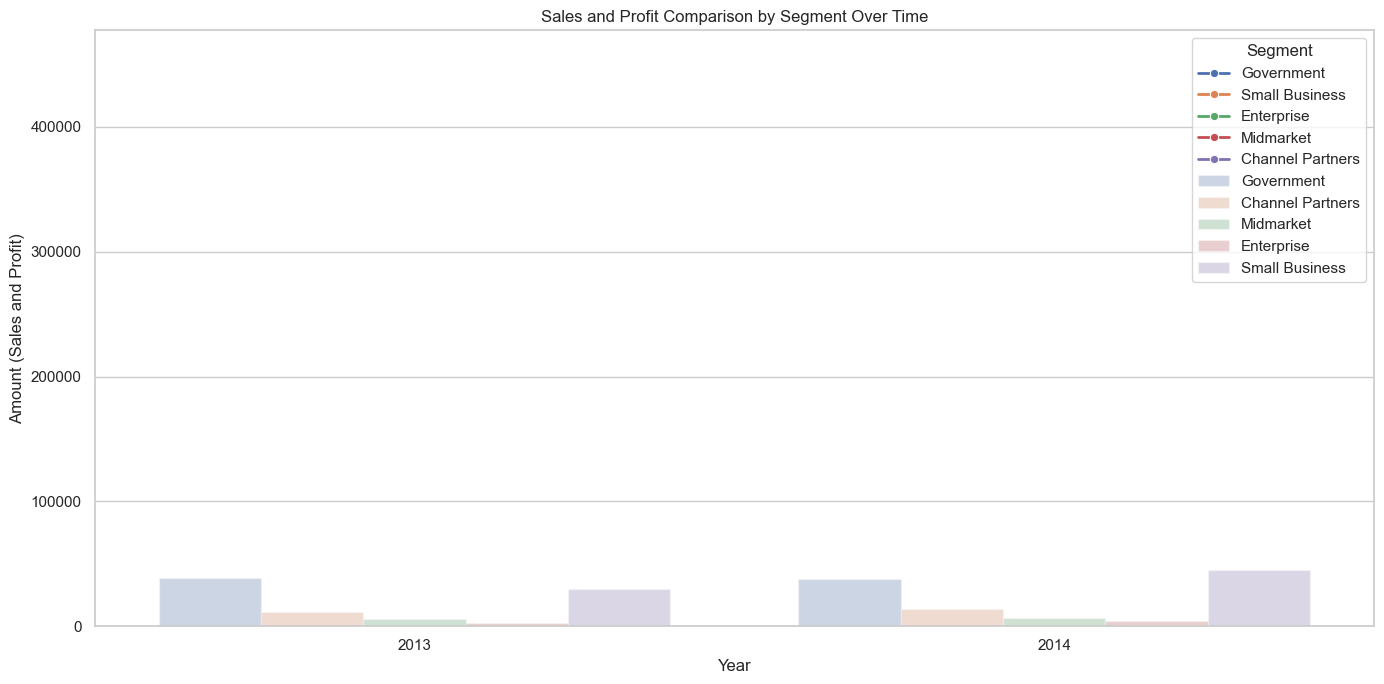

In [199]:
# גרף השוואת רווחיות ומכירות בין סגמנטים
plt.figure(figsize=(14, 7))

# גרף קווים למכירות לפי סגמנט
sns.lineplot(data=df, x='Year', y='Sales', hue='Segment', marker='o', linewidth=2)

# גרף בר לרווחיות לפי סגמנט
sns.barplot(data=df, x='Year', y='Profit', hue='Segment', alpha=0.3, ci=None)

# הוספת כותרת ותגיות
plt.title('Sales and Profit Comparison by Segment Over Time')
plt.xlabel('Year')
plt.ylabel('Amount (Sales and Profit)')
plt.legend(title='Segment')

# הצגת הגרף
plt.tight_layout()
plt.show()


4. מגמות מכירות ורווחיות לפי מדינה (Country):

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_5876/2508717044.py:16: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




Index(['Product', 'Discount Band', 'Units Sold', 'Sale Price', 'Gross Sales',
       'Discounts', 'Sales', 'COGS', 'Profit', 'Date', 'Month Number',
       'ProductID', 'Category', 'Manufacturing Price', 'Segment', 'Country',
       'Year', 'Month Name', 'Discount Impact', 'Profit Margin'],
      dtype='object')


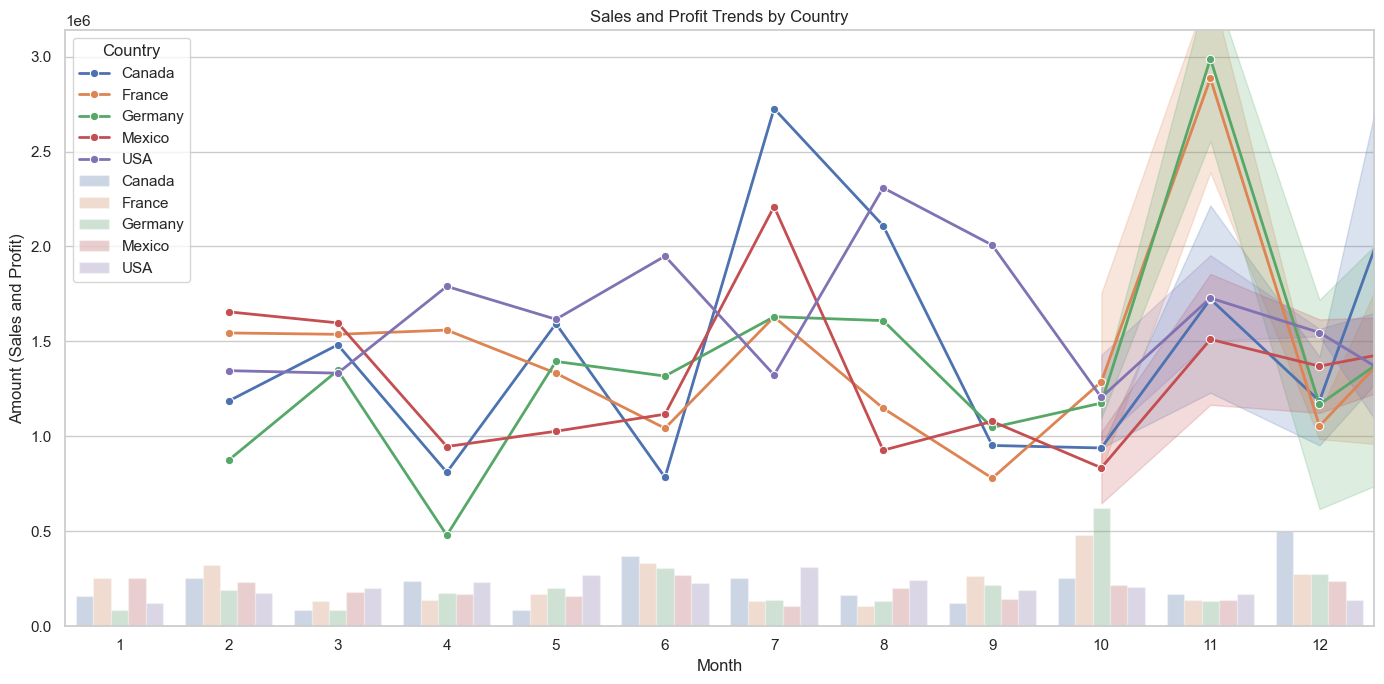

In [200]:
print(df.columns)

# ניתוח מגמות מכירות ורווחיות לפי מדינה
country_trends = df.groupby(['Year', 'Month Number', 'Country']).agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum')
).reset_index()

# גרף השוואת מכירות ורווחיות לפי מדינה לאורך הזמן
plt.figure(figsize=(14, 7))

# גרף קווים למכירות לפי מדינה
sns.lineplot(data=country_trends, x='Month Number', y='Total_Sales', hue='Country', marker='o', linewidth=2)

# גרף בר לרווחיות לפי מדינה
sns.barplot(data=country_trends, x='Month Number', y='Total_Profit', hue='Country', alpha=0.3, ci=None)

# הוספת כותרת ותגיות
plt.title('Sales and Profit Trends by Country')
plt.xlabel('Month')
plt.ylabel('Amount (Sales and Profit)')
plt.legend(title='Country')

# הצגת הגרף
plt.tight_layout()
plt.show()


כדי לענות על השאלות שהצגת, נוכל לבצע כמה ניתוחים באמצעות גרפים ומדדים מתוך הנתונים.

כדי לזהות אילו מוצרים מציגים רווחיות גבוהה עם שיעור הנחות נמוך, עלינו לבדוק את היחס בין רווחיות לבין שיעור הנחות. אנחנו יכולים ליצור גרף שמציג את רווחיות המוצרים מול שיעור ההנחות שלהם.



שלב ראשון: יצירת גרף המראה את רווחיות המוצרים מול שיעור הנחות

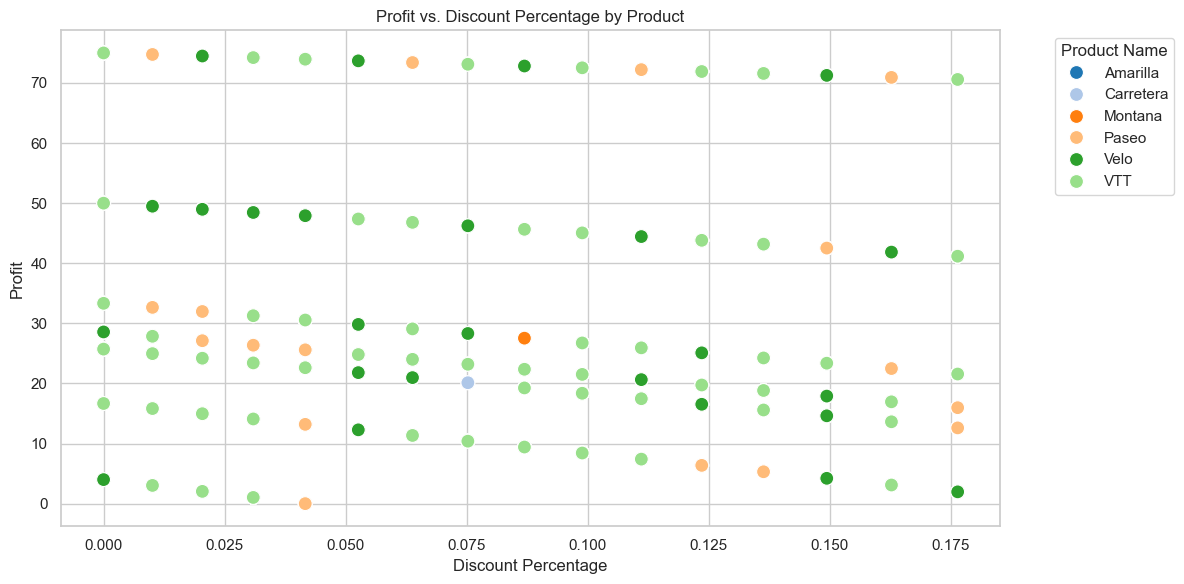

In [201]:
# גרף פיזור של רווחיות מול שיעור הנחות למוצרים
plt.figure(figsize=(12, 6))

# גרף פיזור
sns.scatterplot(data=df, x='Discount Impact', y='Profit Margin', hue='Product', palette='tab20', s=100)
# הוספת כותרת ותגיות
plt.title('Profit vs. Discount Percentage by Product')
plt.xlabel('Discount Percentage')
plt.ylabel('Profit')
plt.legend(title='Product Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# הצגת הגרף
plt.tight_layout()
plt.show()


שלב ראשון: חישוב הקורלציה

In [202]:
correlation = df['Discount Impact'].corr(df['Profit Margin'])
print(f"קורלציה בין שיעור ההנחות לרווחיות: {correlation}")


קורלציה בין שיעור ההנחות לרווחיות: -0.049701643132810114


אם הקורלציה קרובה ל-1 או -1, זה מעיד על קשר חזק בין שני המשתנים. אם היא קרובה ל-0, זה אומר שאין קשר מובהק.

שלב שני: יצירת גרף פיזור (scatter plot)

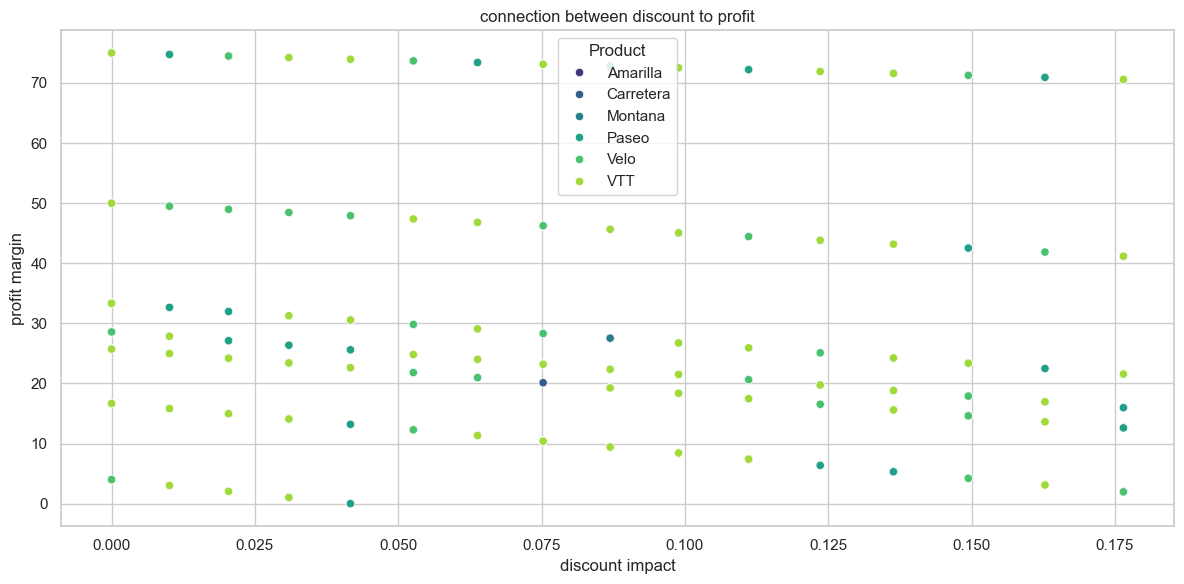

In [203]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Discount Impact', y='Profit Margin', hue='Product', palette='viridis')
plt.title('connection between discount to profit')
plt.xlabel('discount impact')
plt.ylabel('profit margin')
plt.tight_layout()
plt.show()


כדי למצוא את המוצרים/הסגמנטים/המדינות עם ביצועים חלשים, נוכל להגדיר את הקריטריונים על פי Profit Margin ו-Discount Impact, כפי שעשינו קודם. נוכל גם למיין את התוצאות לפי המוצרים/הסגמנטים/המדינות עם הרווחיות הנמוכה ושיעור ההנחות הגבוה.

שלב ראשון: זיהוי מוצרים בעייתיים



In [204]:
profit_margin_threshold = df["Profit Margin"].mean() # לדוגמה, רווחיות נמוכה
discount_impact_threshold = df["Discount Impact"].mean() # לדוגמה, שיעור הנחות גבוה

underperforming_products = df[
    (df["Profit Margin"] < profit_margin_threshold) &  # רווחיות נמוכה
    (df["Discount Impact"] > discount_impact_threshold)  # שיעור הנחות גבוה
]

underperforming_products_summary = underperforming_products.groupby(["Product"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum"),
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean")
).reset_index()

underperforming_products_summary = underperforming_products_summary.sort_values(
    by="Avg_Profit_Margin", ascending=True
)

print(underperforming_products_summary)


     Product   Total_Sales  Total_Profit  Avg_Discount_Impact  \
4        VTT  7.623383e+06    884477.630             0.124770   
2    Montana  6.059466e+06    732865.530             0.129555   
5       Velo  7.771166e+06    752766.215             0.124239   
1  Carretera  3.877559e+06    430979.050             0.134549   
3      Paseo  1.311462e+07   1628478.665             0.131312   
0   Amarilla  5.384244e+06    639921.920             0.126127   

   Avg_Profit_Margin  
4          16.155908  
2          16.285592  
5          16.463202  
1          16.502096  
3          16.888145  
0          17.235398  


שלב שני: זיהוי סגמנטים עם ביצועים חלשים

In [205]:
underperforming_segments = df[
    (df["Profit Margin"] < profit_margin_threshold) & 
    (df["Discount Impact"] > discount_impact_threshold)
]

underperforming_segments_summary = underperforming_segments.groupby(["Segment"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum"),
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean")
).reset_index()

underperforming_segments_summary = underperforming_segments_summary.sort_values(
    by="Avg_Profit_Margin", ascending=True
)

print(underperforming_segments_summary)


          Segment   Total_Sales  Total_Profit  Avg_Discount_Impact  \
2  Small Business  2.159058e+07   1373080.000             0.125440   
0      Government  2.107473e+07   3412551.085             0.127731   
1       Midmarket  1.165128e+06    283857.925             0.132625   

   Avg_Profit_Margin  
2           6.213345  
0          17.835817  
1          24.491665  


שלב שלישי: זיהוי מדינות עם ביצועים חלשים

In [206]:
underperforming_countries = df[
    (df["Profit Margin"] < profit_margin_threshold) & 
    (df["Discount Impact"] > discount_impact_threshold)
]

underperforming_countries_summary = underperforming_countries.groupby(["Country"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum"),
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean")
).reset_index()

underperforming_countries_summary = underperforming_countries_summary.sort_values(
    by="Avg_Profit_Margin", ascending=True
)

print(underperforming_countries_summary)


   Country   Total_Sales  Total_Profit  Avg_Discount_Impact  Avg_Profit_Margin
4      USA  1.117129e+07   1172089.150             0.131092          15.675309
3   Mexico  9.393238e+06   1116998.350             0.128032          15.908725
0   Canada  1.114698e+07   1326428.155             0.134102          15.973623
1   France  6.327735e+06    756297.975             0.125671          17.249175
2  Germany  5.791185e+06    697675.380             0.121361          18.607611


1. ממוצע שיעור הרווחיות ושיעור ההנחות לפי מוצר

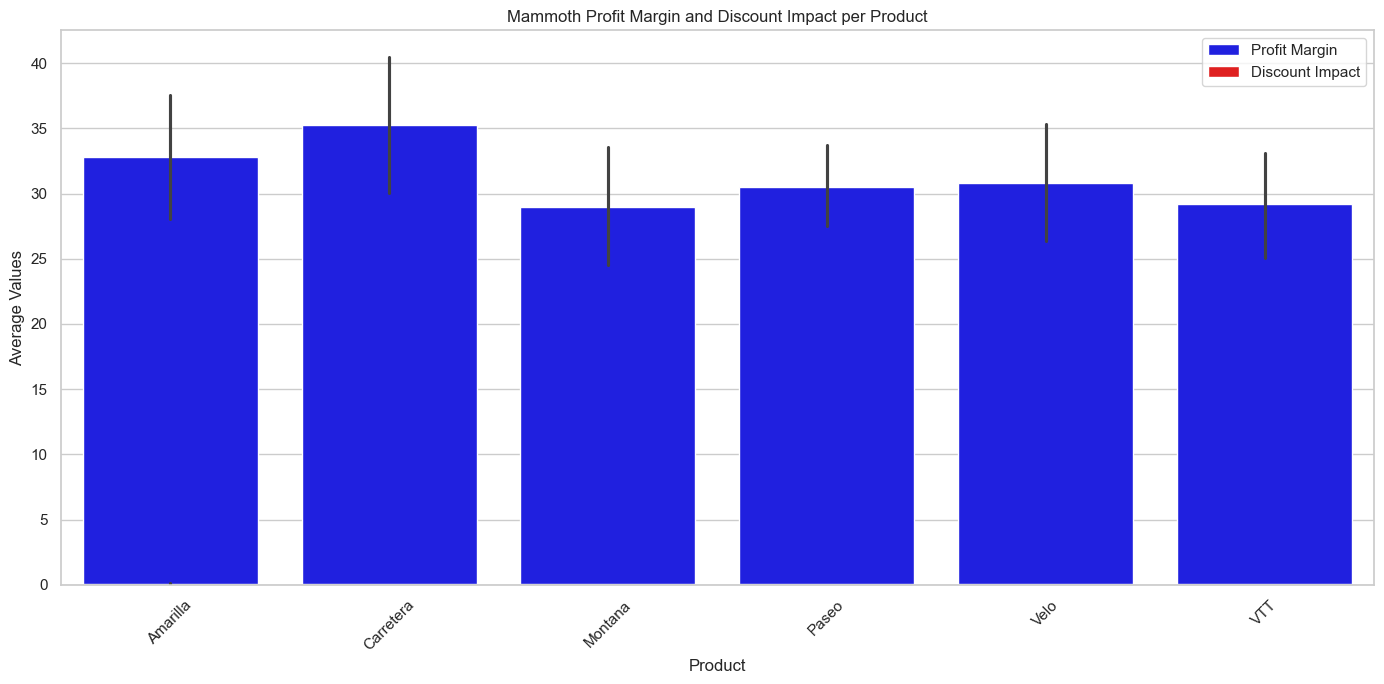

In [207]:
plt.figure(figsize=(14, 7))
sns.barplot(data=df, x='Product', y='Profit Margin', color='blue', label='Profit Margin')
sns.barplot(data=df, x='Product', y='Discount Impact', color='red', label='Discount Impact')

plt.title('Mammoth Profit Margin and Discount Impact per Product')
plt.xlabel('Product')
plt.ylabel('Average Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

2. התפלגות מספר העסקאות לפי סגמנטים

כדי לבדוק אם יש קשר מובהק בין שיעור ההנחות (Discount Impact) לרווחיות (Profit Margin), נוכל לחשב את הקורלציה בין שני המשתנים הללו וליצור גרף פיזור (scatter plot) כדי לראות את הקשר.

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_5876/1477926172.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




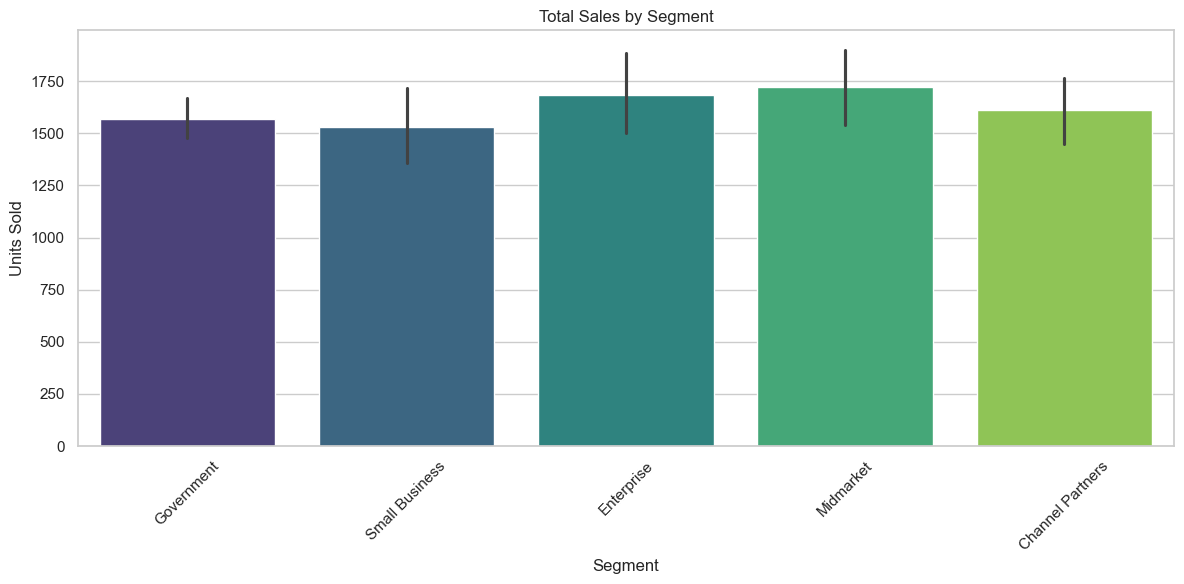

In [208]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Segment', y='Units Sold', palette='viridis')
plt.title('Total Sales by Segment')
plt.xlabel('Segment')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


3. התפלגות שיעור הרווחיות לפי סגמנטים

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_5876/2968810282.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




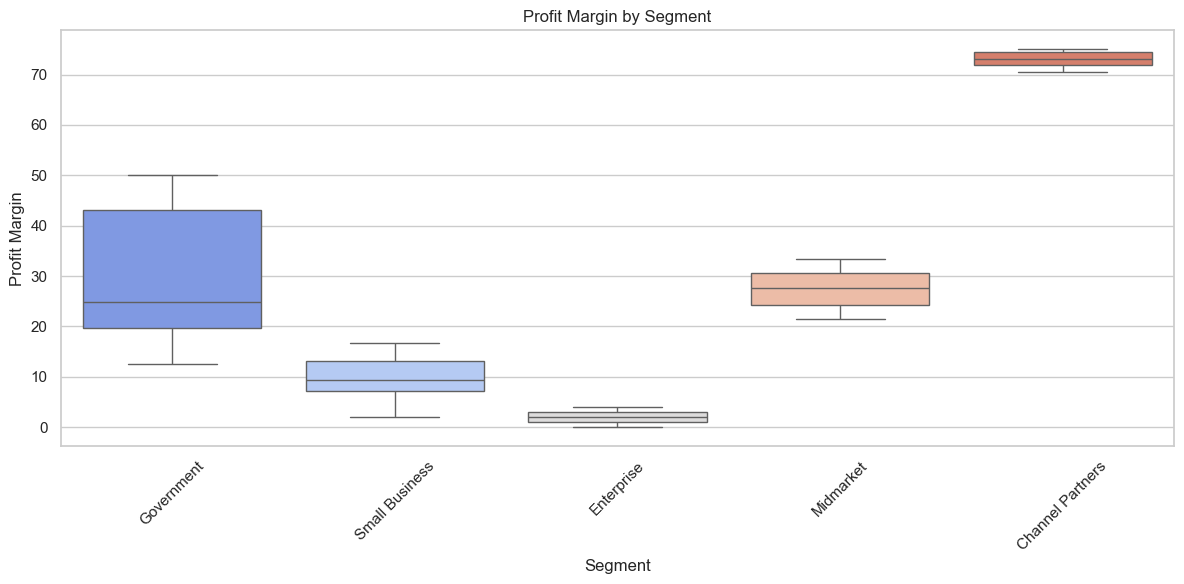

In [209]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Segment', y='Profit Margin', palette='coolwarm')
plt.title('Profit Margin by Segment')
plt.xlabel('Segment')
plt.ylabel('Profit Margin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


4. סך הרווחים לפי מדינות

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_5876/768974575.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




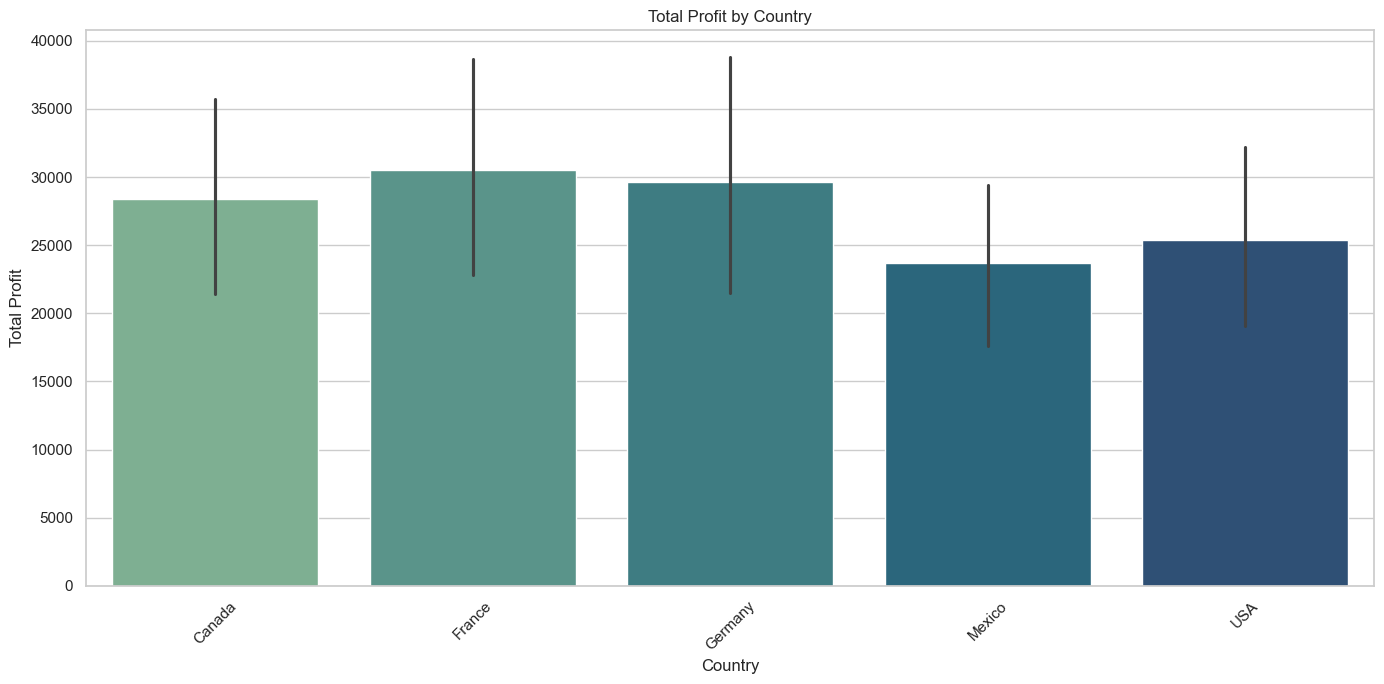

In [210]:
plt.figure(figsize=(14, 7))
sns.barplot(data=df, x='Country', y='Profit', palette='crest')
plt.title('Total Profit by Country')
plt.xlabel('Country')
plt.ylabel('Total Profit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5. מגמות של ממוצע שיעור הרווחיות לאורך זמן לפי מדינה

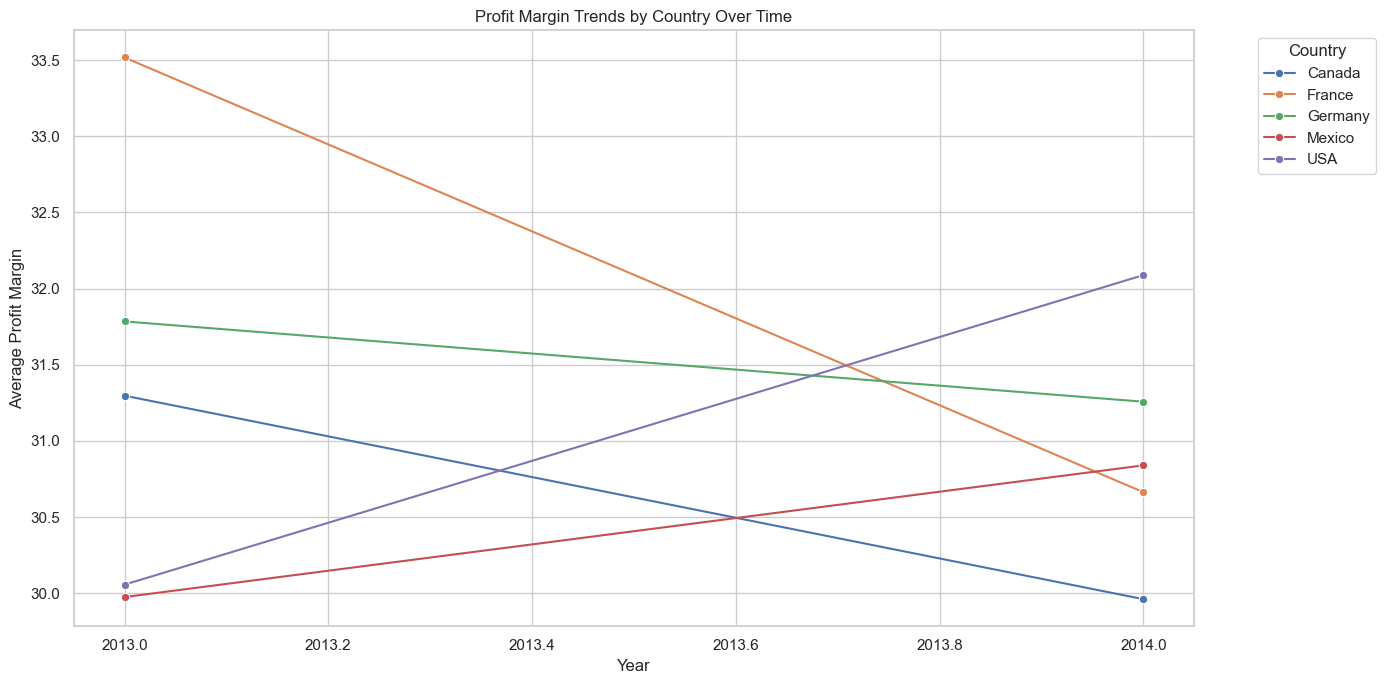

In [211]:
# Ensure 'Date' column is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Group data by Year and Country and calculate the mean Profit Margin
df_grouped = df.groupby(['Year', 'Country'])['Profit Margin'].mean().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_grouped, x='Year', y='Profit Margin', hue='Country', marker='o')
plt.title('Profit Margin Trends by Country Over Time')
plt.xlabel('Year')
plt.ylabel('Average Profit Margin')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [212]:
df['Date'] = pd.to_datetime(df['Date'])  # Ensure the Date column is in datetime format
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.strftime('%B')  # For showing the month name

# Group by Year and Month, then calculate the metrics
monthly_data = df.groupby(['Year', 'Month_Name'], as_index=False).agg(
    total_sales=('Sales', 'sum'),
    total_profit=('Profit', 'sum'),
    avg_profit_margin=('Profit Margin', 'mean'),
    avg_discount_impact=('Discount Impact', 'mean')
)

מכירות ורווחים לפי חודשים

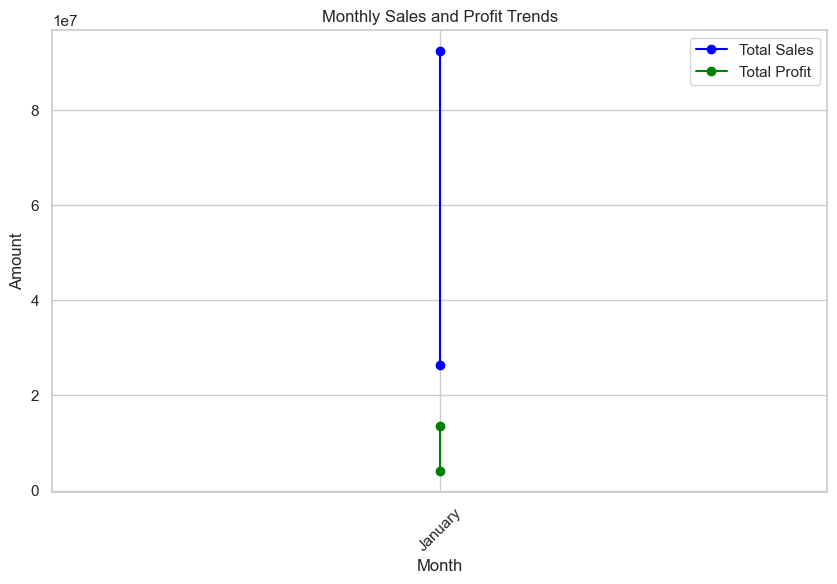

In [213]:
plt.figure(figsize=(10, 6))

plt.plot(monthly_data['Month_Name'], monthly_data['total_sales'], label='Total Sales', marker='o', color='blue')
plt.plot(monthly_data['Month_Name'], monthly_data['total_profit'], label='Total Profit', marker='o', color='green')

plt.title('Monthly Sales and Profit Trends')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

 שיעור הרווחיות לפי חודשים

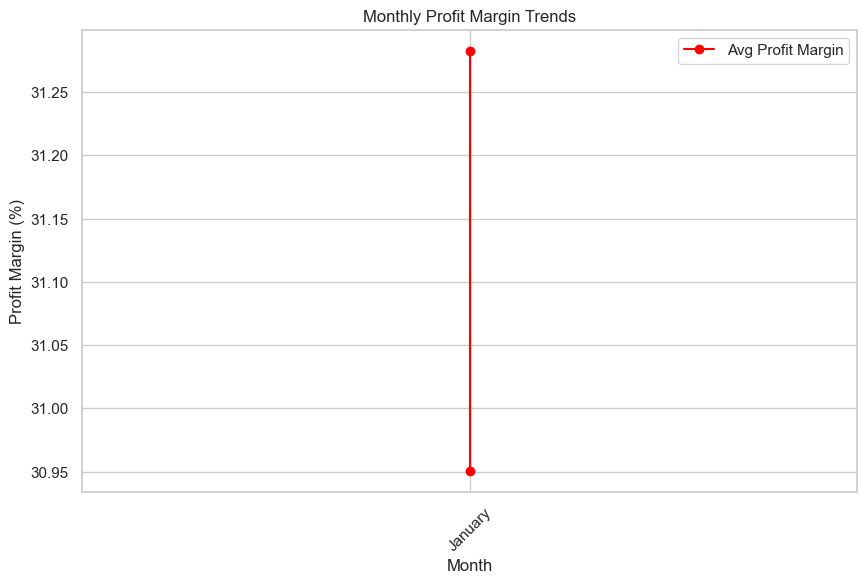

In [214]:
plt.figure(figsize=(10, 6))

plt.plot(monthly_data['Month_Name'], monthly_data['avg_profit_margin'], label='Avg Profit Margin', marker='o', color='red')

plt.title('Monthly Profit Margin Trends')
plt.xlabel('Month')
plt.ylabel('Profit Margin (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

 שיעור הנחות לפי חודשים

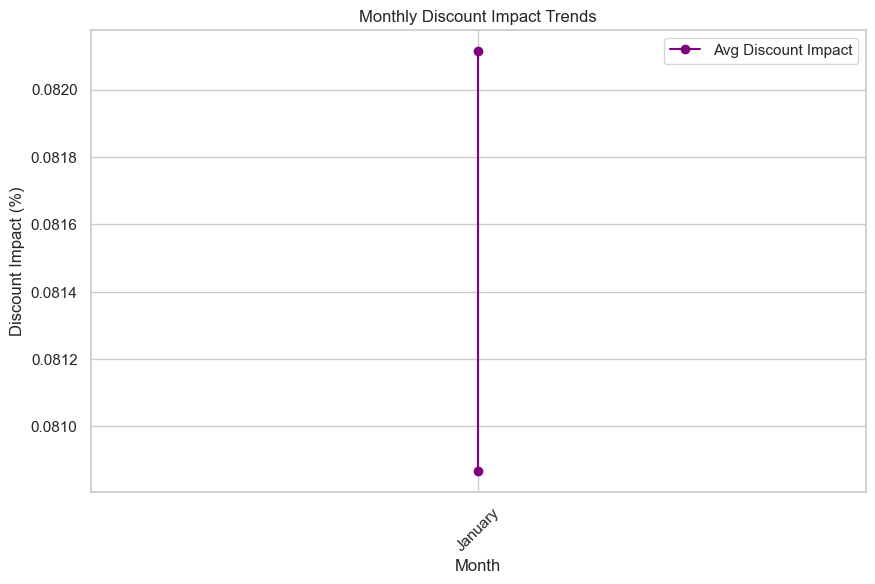

In [215]:
plt.figure(figsize=(10, 6))

plt.plot(monthly_data['Month_Name'], monthly_data['avg_discount_impact'], label='Avg Discount Impact', marker='o', color='purple')

plt.title('Monthly Discount Impact Trends')
plt.xlabel('Month')
plt.ylabel('Discount Impact (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

יצירה של 3 מטריקות חדשות וההסבר עליהן  2.3 

In [216]:
# Metric 1: Revenue Contribution
df['Revenue Contribution (%)'] = (df['Gross Sales'] / df['Gross Sales'].sum()) * 100
# Metric 2: Discount Effectiveness
# Avoid dividing by zero for entries with no discounts
df['Discount Effectiveness'] = df.apply(
    lambda row: row['Profit'] / row['Discounts'] if row['Discounts'] != 0 else None, axis=1
)
df['Cost-to-Sales Ratio (%)'] = (df['COGS'] / df['Sales']) * 100
output_filename = "create_three_metrics.csv"
df.to_csv(output_filename, index=False)

יצירת טבלאות מסכמות בעזרת פיווטים 

טבלת מוצר (Product):


In [217]:

# Pivot Table for Product
product_table = pd.pivot_table(
    df,
    values=["Profit Margin", "Discount Impact", "Profit", "Sales"],
    index="Product",
    aggfunc={
        "Profit Margin": "mean",
        "Discount Impact": "mean",
        "Profit": "sum",
        "Sales": "sum"
    }
).rename(columns={
    "Profit Margin": "Avg_Profit_Margin",
    "Discount Impact": "Avg_Discount_Impact",
    "Profit": "Total_Profit",
    "Sales": "Total_Sales"
})
product_table["Total_Transactions"] = df.groupby("Product")["Units Sold"].count()
output_filename = "product_table_using_pivot.csv"
product_table.to_csv(output_filename, index=False)

טבלת סגמנט (Segment):

In [218]:
# Pivot Table for Segment
segment_table = pd.pivot_table(
    df,
    values=["Profit Margin", "Discount Impact", "Profit", "Sales"],
    index="Segment",
    aggfunc={
        "Profit Margin": "mean",
        "Discount Impact": "mean",
        "Profit": "sum",
        "Sales": "sum"
    }
).rename(columns={
    "Profit Margin": "Avg_Profit_Margin",
    "Discount Impact": "Avg_Discount_Impact",
    "Profit": "Total_Profit",
    "Sales": "Total_Sales"
})
segment_table["Total_Transactions"] = df.groupby("Segment")["Units Sold"].count()
output_filename = "segment_table_using_pivot.csv"
segment_table.to_csv(output_filename, index=False)

טבלת אזור גיאוגרפי (Country):


In [219]:
# Pivot Table for Country
country_table = pd.pivot_table(
    df,
    values=["Profit Margin", "Discount Impact", "Profit", "Sales"],
    index="Country",
    aggfunc={
        "Profit Margin": "mean",
        "Discount Impact": "mean",
        "Profit": "sum",
        "Sales": "sum",
    }
).rename(columns={
    "Profit Margin": "Avg_Profit_Margin",
    "Discount Impact": "Avg_Discount_Impact",
    "Profit": "Total_Profit",
    "Sales": "Total_Sales"
})
country_table["Total_Transactions"] = df.groupby("Country")["Units Sold"].count()
country_table = country_table.reset_index()

output_filename = "country_table_using_pivot.csv"
country_table.to_csv(output_filename, index=False)

זיהוי מגמות לאורך זמן 


ניתוח מגמות לפי חודשים (Monthly Trends):

In [220]:
# Monthly Trends Analysis
monthly_trends = df.groupby('Month Number').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Discount_Impact=('Discount Impact', 'mean'),
    Avg_Profit_Margin=('Profit Margin', 'mean')
).reset_index()
output_filename = "monthly_trends.csv"
monthly_trends.to_csv(output_filename, index=False)

ניתוח מגמות לפי שנים (Yearly Trends):


In [221]:
# Annual Trends Analysis
annual_trends = df.groupby('Year').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Discount_Impact=('Discount Impact', 'mean'),
    Avg_Profit_Margin=('Profit Margin', 'mean')
).reset_index()
output_filename = "annual_trends.csv"
annual_trends.to_csv(output_filename, index=False)

ניתוח של מגמות רבעוניות ,הסבר נמצא 1.6 והקוד למטה מייצר את הטבלה 

In [222]:

# Create a Quarter column
df['Quarter'] = pd.to_datetime(df['Date']).dt.quarter

# Group by Quarter and Product to calculate quarterly trends
quarterly_trends = df.groupby(['Quarter', 'Product']).agg(
    Total_Sales=('Sales', 'sum'),
    Avg_Profit_Margin=('Profit Margin', 'mean'),
    Total_Discounts=('Discounts', 'sum'),
    Total_Profit=('Profit', 'sum')
).reset_index()

# Rename columns for clarity
quarterly_trends = quarterly_trends.rename(columns={
    'Total_Sales': 'Total_Quarterly_Sales',
    'Avg_Profit_Margin': 'Avg_Quarterly_Profit_Margin',
    'Total_Discounts': 'Total_Quarterly_Discounts',
    'Total_Profit': 'Total_Quarterly_Profit'
})

output_filename = "quarterly_trends.csv"
quarterly_trends.to_csv(output_filename, index=False)

יצירת פילטרים מותאמים לניתוח ממוקד ויזהוי בעיות עסקיות


זיהוי מוצרים בעייתיים


In [223]:
# Calculate overall averages for reference
avg_discount_impact = df["Discount Impact"].mean()
avg_profit_margin = df["Profit Margin"].mean()

# Filter problematic products
problematic_products = df[
    (df["Discount Impact"] > avg_discount_impact) &  # Higher than average discount impact
    (df["Profit Margin"] < avg_profit_margin)        # Lower than average profit margin
]

# Aggregate results at the product level
problematic_products_summary = problematic_products.groupby("Product").agg(
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean"),
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum")
).reset_index()

# Sort by highest discount impact
problematic_products_summary = problematic_products_summary.sort_values(
    by="Avg_Discount_Impact", ascending=False
)

output_filename = "problematic_products_summary.csv"
problematic_products_summary.to_csv(output_filename, index=False)


בניית טבלה שתעזור לי למצוא מוצרים המציגים ביצועים חלשים 

In [224]:
# Define thresholds for filtering
profit_margin_threshold = 7  # Bottom quartile (low profitability)
discount_impact_threshold = 8.5  # Top quartile (high discount impact)

# Filter for underperforming products
underperforming_products = df[
    (df["Profit Margin"] < profit_margin_threshold) &  # Low profitability
    (df["Discount Impact"] > discount_impact_threshold)  # High discount impact
]

# Aggregate data at the product level
underperforming_products_summary = underperforming_products.groupby(["Product", "Segment"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum"),
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean")
).reset_index()

# Sort by Profit Margin (ascending order)
underperforming_products_summary = underperforming_products_summary.sort_values(
    by="Avg_Profit_Margin", ascending=True
)

# Rename columns for clarity
underperforming_products_summary.rename(columns={
    "Total_Sales": "Sales",
    "Total_Profit": "Profit",
    "Avg_Discount_Impact": "Discount Impact",
    "Avg_Profit_Margin": "Profit Margin"
}, inplace=True)

# Display the final summary table
print(underperforming_products_summary)


Empty DataFrame
Columns: [Product, Segment, Sales, Profit, Discount Impact, Profit Margin]
Index: []


קיבוץ הנתונים לפי שנה

In [225]:
yearly_data = df.groupby('Year', as_index=False).agg(
    total_sales=('Sales', 'sum'),
    total_profit=('Profit', 'sum'),
    avg_profit_margin=('Profit Margin', 'mean'),
    avg_discount_impact=('Discount Impact', 'mean')
)

 מכירות ורווח לאורך השנים

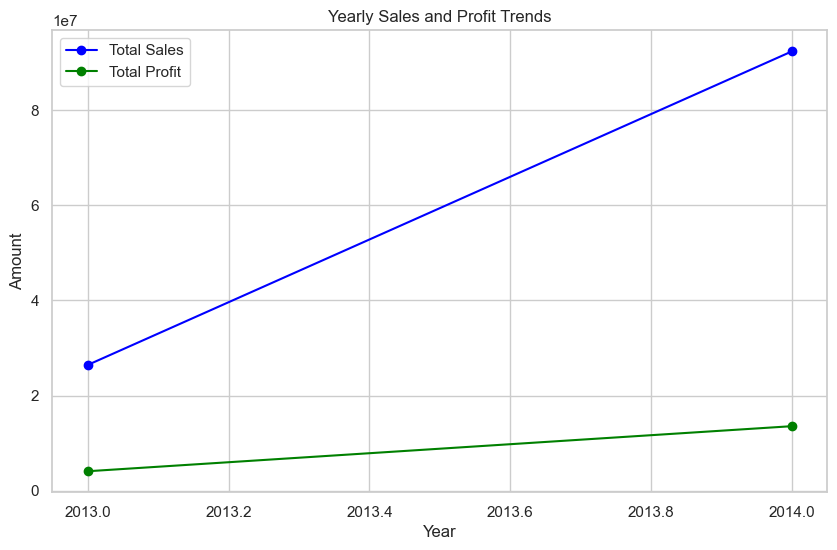

In [226]:
plt.figure(figsize=(10, 6))

# גרף המכירות
plt.plot(yearly_data['Year'], yearly_data['total_sales'], label='Total Sales', marker='o', color='blue')
# גרף הרווחים
plt.plot(yearly_data['Year'], yearly_data['total_profit'], label='Total Profit', marker='o', color='green')

plt.title('Yearly Sales and Profit Trends')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

 מגמת רווחיות לאורך השנים

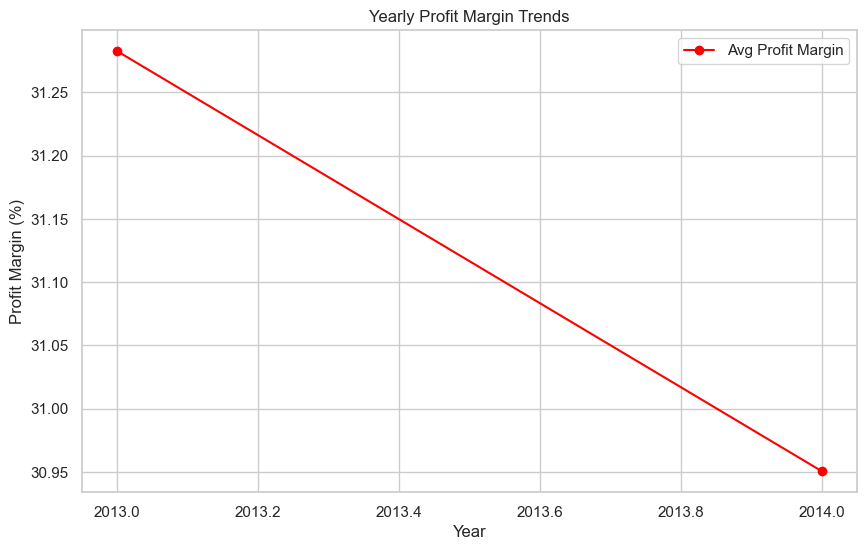

In [227]:
plt.figure(figsize=(10, 6))

plt.plot(yearly_data['Year'], yearly_data['avg_profit_margin'], label='Avg Profit Margin', marker='o', color='red')

plt.title('Yearly Profit Margin Trends')
plt.xlabel('Year')
plt.ylabel('Profit Margin (%)')
plt.legend()
plt.grid(True)
plt.show()

מגמת השפעת ההנחות לאורך השנים

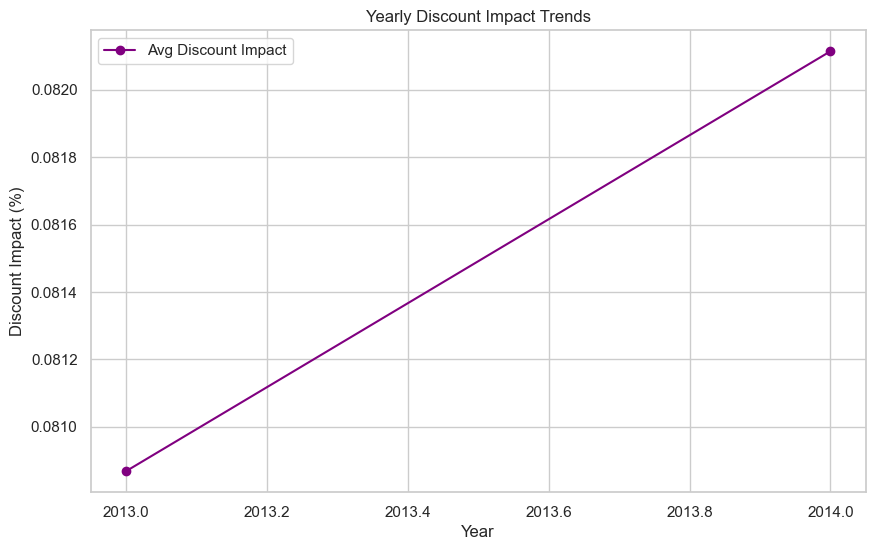

In [228]:
plt.figure(figsize=(10, 6))

plt.plot(yearly_data['Year'], yearly_data['avg_discount_impact'], label='Avg Discount Impact', marker='o', color='purple')

plt.title('Yearly Discount Impact Trends')
plt.xlabel('Year')
plt.ylabel('Discount Impact (%)')
plt.legend()
plt.grid(True)
plt.show()

יצירה של 3 מטריקות חדשות וההסבר עליהן  2.3 

In [229]:
# Metric 1: Revenue Contribution
df['Revenue Contribution (%)'] = (df['Gross Sales'] / df['Gross Sales'].sum()) * 100
# Metric 2: Discount Effectiveness
# Avoid dividing by zero for entries with no discounts
df['Discount Effectiveness'] = df.apply(
    lambda row: row['Profit'] / row['Discounts'] if row['Discounts'] != 0 else None, axis=1
)
df['Cost-to-Sales Ratio (%)'] = (df['COGS'] / df['Sales']) * 100
output_filename = "create_three_metrics.csv"
df.to_csv(output_filename, index=False)

יצירת טבלאות מסכמות בעזרת פיווטים 

טבלת מוצר (Product):


In [230]:

# Pivot Table for Product
product_table = pd.pivot_table(
    df,
    values=["Profit Margin", "Discount Impact", "Profit", "Sales"],
    index="Product",
    aggfunc={
        "Profit Margin": "mean",
        "Discount Impact": "mean",
        "Profit": "sum",
        "Sales": "sum"
    }
).rename(columns={
    "Profit Margin": "Avg_Profit_Margin",
    "Discount Impact": "Avg_Discount_Impact",
    "Profit": "Total_Profit",
    "Sales": "Total_Sales"
})
product_table["Total_Transactions"] = df.groupby("Product")["Units Sold"].count()
output_filename = "product_table_using_pivot.csv"
product_table.to_csv(output_filename, index=False)

טבלת סגמנט (Segment):

In [231]:
# Pivot Table for Segment
segment_table = pd.pivot_table(
    df,
    values=["Profit Margin", "Discount Impact", "Profit", "Sales"],
    index="Segment",
    aggfunc={
        "Profit Margin": "mean",
        "Discount Impact": "mean",
        "Profit": "sum",
        "Sales": "sum"
    }
).rename(columns={
    "Profit Margin": "Avg_Profit_Margin",
    "Discount Impact": "Avg_Discount_Impact",
    "Profit": "Total_Profit",
    "Sales": "Total_Sales"
})
segment_table["Total_Transactions"] = df.groupby("Segment")["Units Sold"].count()
output_filename = "segment_table_using_pivot.csv"
segment_table.to_csv(output_filename, index=False)

טבלת אזור גיאוגרפי (Country):


In [232]:
# Pivot Table for Country
country_table = pd.pivot_table(
    df,
    values=["Profit Margin", "Discount Impact", "Profit", "Sales"],
    index="Country",
    aggfunc={
        "Profit Margin": "mean",
        "Discount Impact": "mean",
        "Profit": "sum",
        "Sales": "sum",
    }
).rename(columns={
    "Profit Margin": "Avg_Profit_Margin",
    "Discount Impact": "Avg_Discount_Impact",
    "Profit": "Total_Profit",
    "Sales": "Total_Sales"
})
country_table["Total_Transactions"] = df.groupby("Country")["Units Sold"].count()
country_table = country_table.reset_index()

output_filename = "country_table_using_pivot.csv"
country_table.to_csv(output_filename, index=False)

זיהוי מגמות לאורך זמן 


ניתוח מגמות לפי חודשים (Monthly Trends):

In [233]:
# Monthly Trends Analysis
monthly_trends = df.groupby('Month Number').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Discount_Impact=('Discount Impact', 'mean'),
    Avg_Profit_Margin=('Profit Margin', 'mean')
).reset_index()
output_filename = "monthly_trends.csv"
monthly_trends.to_csv(output_filename, index=False)

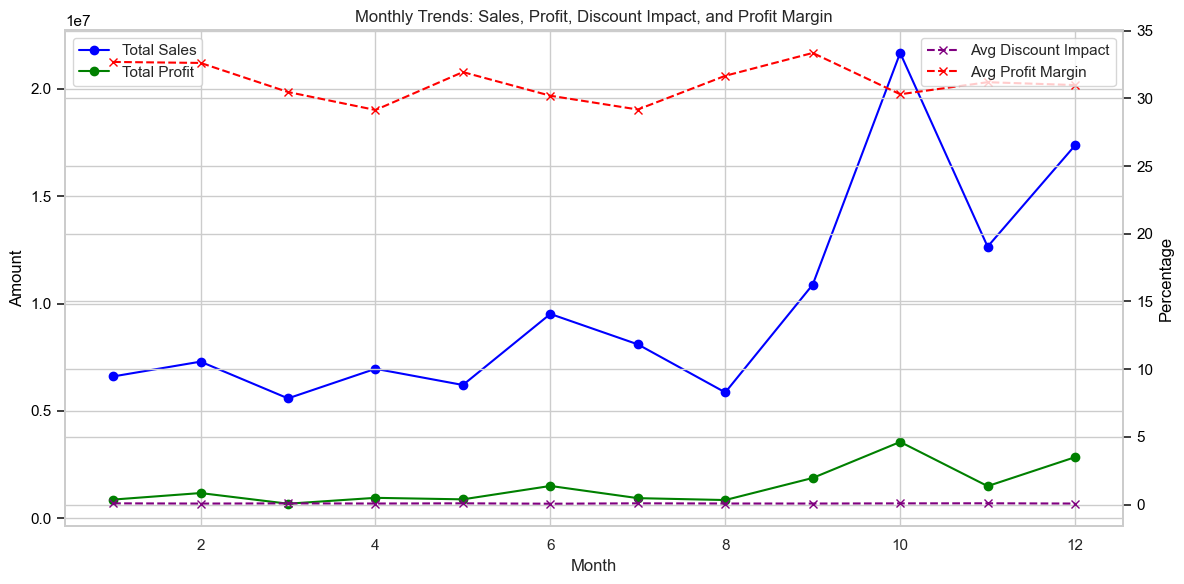

In [234]:

# Set up the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Total Sales and Total Profit on the primary y-axis
ax1.plot(monthly_trends['Month Number'], monthly_trends['Total_Sales'], label='Total Sales', color='blue', marker='o')
ax1.plot(monthly_trends['Month Number'], monthly_trends['Total_Profit'], label='Total Profit', color='green', marker='o')

# Labels for the primary y-axis
ax1.set_xlabel('Month')
ax1.set_ylabel('Amount', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis for Avg Discount Impact and Avg Profit Margin
ax2 = ax1.twinx()

# Plot Avg Discount Impact and Avg Profit Margin on the secondary y-axis
ax2.plot(monthly_trends['Month Number'], monthly_trends['Avg_Discount_Impact'], label='Avg Discount Impact', color='purple', linestyle='--', marker='x')
ax2.plot(monthly_trends['Month Number'], monthly_trends['Avg_Profit_Margin'], label='Avg Profit Margin', color='red', linestyle='--', marker='x')

# Labels for the secondary y-axis
ax2.set_ylabel('Percentage', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('Monthly Trends: Sales, Profit, Discount Impact, and Profit Margin')
fig.tight_layout()

# Combine legends from both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()


ניתוח מגמות לפי שנים (Yearly Trends):


In [235]:
# Annual Trends Analysis
annual_trends = df.groupby('Year').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Discount_Impact=('Discount Impact', 'mean'),
    Avg_Profit_Margin=('Profit Margin', 'mean')
).reset_index()
output_filename = "annual_trends.csv"
annual_trends.to_csv(output_filename, index=False)

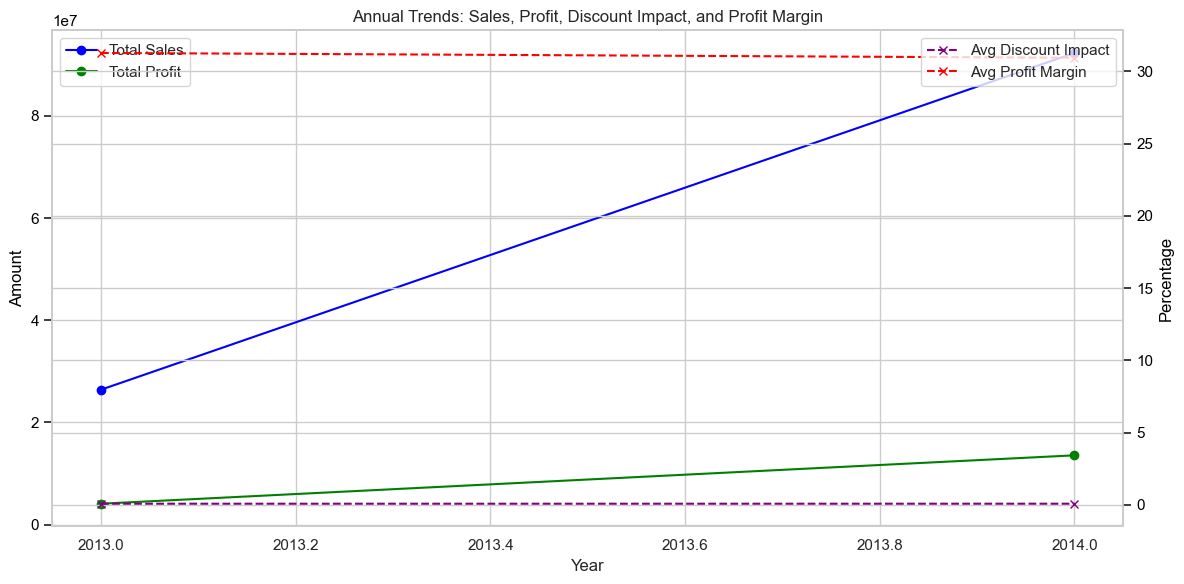

In [236]:
# Set up the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Total Sales and Total Profit on the primary y-axis
ax1.plot(annual_trends['Year'], annual_trends['Total_Sales'], label='Total Sales', color='blue', marker='o')
ax1.plot(annual_trends['Year'], annual_trends['Total_Profit'], label='Total Profit', color='green', marker='o')

# Labels for the primary y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Amount', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis for Avg Discount Impact and Avg Profit Margin
ax2 = ax1.twinx()

# Plot Avg Discount Impact and Avg Profit Margin on the secondary y-axis
ax2.plot(annual_trends['Year'], annual_trends['Avg_Discount_Impact'], label='Avg Discount Impact', color='purple', linestyle='--', marker='x')
ax2.plot(annual_trends['Year'], annual_trends['Avg_Profit_Margin'], label='Avg Profit Margin', color='red', linestyle='--', marker='x')

# Labels for the secondary y-axis
ax2.set_ylabel('Percentage', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('Annual Trends: Sales, Profit, Discount Impact, and Profit Margin')
fig.tight_layout()

# Combine legends from both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()


ניתוח של מגמות רבעוניות ,הסבר נמצא 1.6 והקוד למטה מייצר את הטבלה 

In [237]:

# Create a Quarter column
df['Quarter'] = pd.to_datetime(df['Date']).dt.quarter

# Group by Quarter and Product to calculate quarterly trends
quarterly_trends = df.groupby(['Quarter', 'Product']).agg(
    Total_Sales=('Sales', 'sum'),
    Avg_Profit_Margin=('Profit Margin', 'mean'),
    Total_Discounts=('Discounts', 'sum'),
    Total_Profit=('Profit', 'sum')
).reset_index()

# Rename columns for clarity
quarterly_trends = quarterly_trends.rename(columns={
    'Total_Sales': 'Total_Quarterly_Sales',
    'Avg_Profit_Margin': 'Avg_Quarterly_Profit_Margin',
    'Total_Discounts': 'Total_Quarterly_Discounts',
    'Total_Profit': 'Total_Quarterly_Profit'
})

output_filename = "quarterly_trends.csv"
quarterly_trends.to_csv(output_filename, index=False)

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_5876/2548415480.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




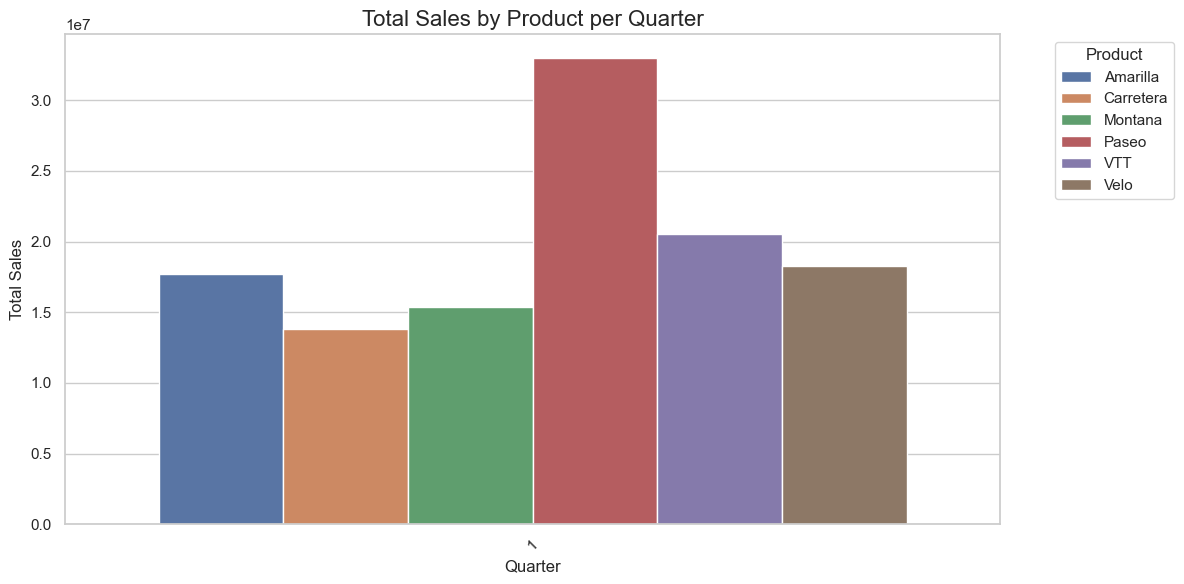

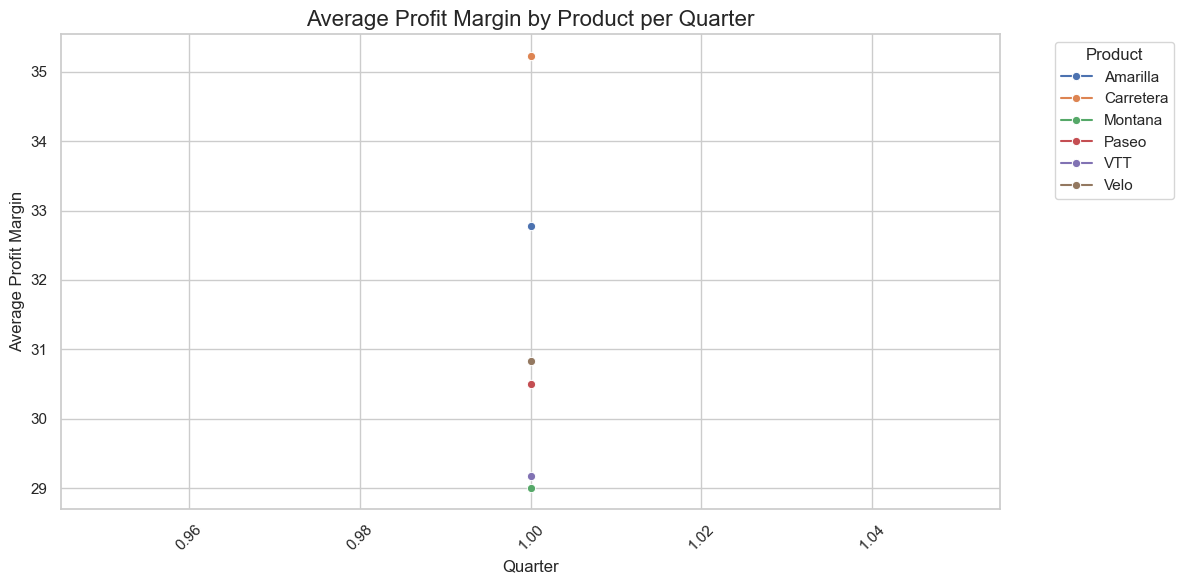

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_5876/2548415480.py:27: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




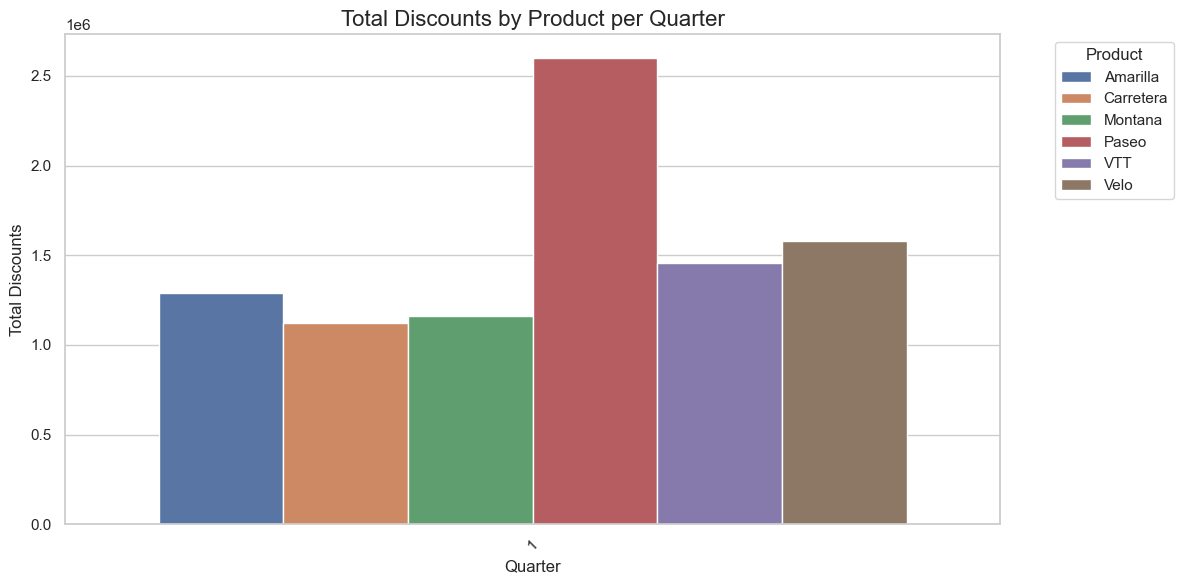

/var/folders/lq/ljvjkwbs7db9y2l6pq_25mlm0000gn/T/ipykernel_5876/2548415480.py:38: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




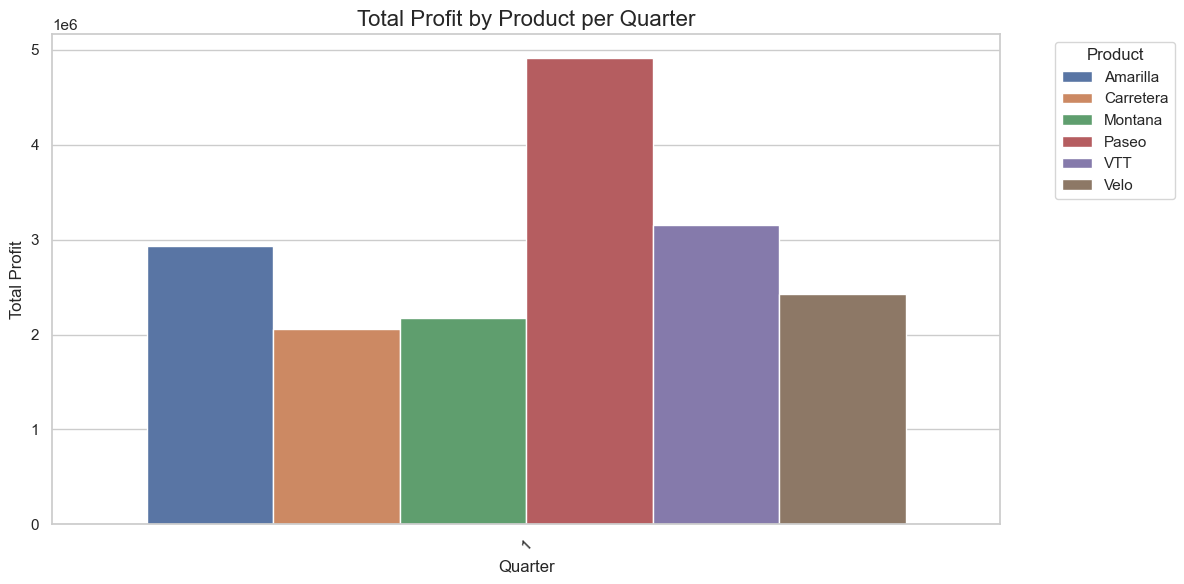

In [238]:
sns.set(style="whitegrid")

# סך מכירות וסך ריוחיות פר מוצר
plt.figure(figsize=(12, 6))
sales_profit_plot = sns.barplot(data=quarterly_trends, x='Quarter', y='Total_Quarterly_Sales', hue='Product', ci=None)
sales_profit_plot.set_title('Total Sales by Product per Quarter', fontsize=16)
sales_profit_plot.set_ylabel('Total Sales')
sales_profit_plot.set_xlabel('Quarter')
plt.xticks(rotation=45)
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ממוצע ריוחיות פר מוצר
plt.figure(figsize=(12, 6))
profit_margin_plot = sns.lineplot(data=quarterly_trends, x='Quarter', y='Avg_Quarterly_Profit_Margin', hue='Product', marker='o')
profit_margin_plot.set_title('Average Profit Margin by Product per Quarter', fontsize=16)
profit_margin_plot.set_ylabel('Average Profit Margin')
profit_margin_plot.set_xlabel('Quarter')
plt.xticks(rotation=45)
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# הנחה פר מוצר
plt.figure(figsize=(12, 6))
discount_plot = sns.barplot(data=quarterly_trends, x='Quarter', y='Total_Quarterly_Discounts', hue='Product', ci=None)
discount_plot.set_title('Total Discounts by Product per Quarter', fontsize=16)
discount_plot.set_ylabel('Total Discounts')
discount_plot.set_xlabel('Quarter')
plt.xticks(rotation=45)
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ריווחיות פר מוצר
plt.figure(figsize=(12, 6))
profit_plot = sns.barplot(data=quarterly_trends, x='Quarter', y='Total_Quarterly_Profit', hue='Product', ci=None)
profit_plot.set_title('Total Profit by Product per Quarter', fontsize=16)
profit_plot.set_ylabel('Total Profit')
profit_plot.set_xlabel('Quarter')
plt.xticks(rotation=45)
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


יצירת פילטרים מותאמים לניתוח ממוקד ויזהוי בעיות עסקיות


זיהוי מוצרים בעייתיים


In [239]:
avg_discount_impact = df["Discount Impact"].mean()
avg_profit_margin = df["Profit Margin"].mean()


problematic_products = df[
    (df["Discount Impact"] > avg_discount_impact) &  
    (df["Profit Margin"] < avg_profit_margin)    
]

# Aggregate results at the product level
problematic_products_summary = problematic_products.groupby("Product").agg(
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean"),
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum")
).reset_index()

# Sort by highest discount impact
problematic_products_summary = problematic_products_summary.sort_values(
    by="Avg_Discount_Impact", ascending=False
)

output_filename = "problematic_products_summary.csv"
problematic_products_summary.to_csv(output_filename, index=False)


 גרף פיזור (Scatter Plot) של הנחות מול רווחיות

In [240]:
fig1 = px.scatter(problematic_products_summary,
                  x='Avg_Discount_Impact', 
                  y='Avg_Profit_Margin',
                  size='Total_Sales',  # גודל הנקודות לפי מכירות
                  color='Product',     # צבע לפי המוצר
                  hover_name='Product',  # הצגת שם המוצר בהובר
                  title='Discount Impact vs Profit Margin by Product',
                  labels={'Avg_Discount_Impact': 'Average Discount Impact', 
                          'Avg_Profit_Margin': 'Average Profit Margin'},
                  template='plotly_dark')  # ניתן לבחור תבנית צבעים

# הצגת הגרף
fig1.show()

גרף עמודות (Bar Chart) עם סך מכירות ורווחיות

In [241]:
fig2 = px.bar(problematic_products_summary,
              x='Product',
              y=['Total_Sales', 'Total_Profit'],
              title='Total Sales and Profit for Problematic Products',
              labels={'Total_Sales': 'Total Sales', 'Total_Profit': 'Total Profit'},
              barmode='group',  # הצגת עמודות מקבילות
              template='plotly_dark')

# הצגת הגרף
fig2.show()

גרף קו (Line Chart) של השפעת הנחות מול רווחיות לאורך זמן

In [242]:
fig3 = px.line(problematic_products_summary,
               x='Product',  # או 'Date' אם אתה רוצה לפי זמן
               y='Avg_Discount_Impact',
               title='Trend of Discount Impact vs Profit Margin Over Time',
               labels={'Avg_Discount_Impact': 'Average Discount Impact'},
               template='plotly_dark')

# הצגת הגרף
fig3.show()

בניית טבלה שתעזור לי למצוא מוצרים המציגים ביצועים חלשים 

In [243]:
# Define thresholds for filtering
profit_margin_threshold = df["Profit Margin"].quantile() # Bottom quartile (low profitability)
discount_impact_threshold = df["Discount Impact"].quantile() # Top quartile (high discount impact)

# Filter for underperforming products
underperforming_products = df[
    (df["Profit Margin"] < profit_margin_threshold) &  # Low profitability
    (df["Discount Impact"] > discount_impact_threshold)  # High discount impact
]

# Aggregate data at the product level
underperforming_products_summary = underperforming_products.groupby(["Product", "Segment"]).agg(
    Total_Sales=("Sales", "sum"),
    Total_Profit=("Profit", "sum"),
    Avg_Discount_Impact=("Discount Impact", "mean"),
    Avg_Profit_Margin=("Profit Margin", "mean")
).reset_index()

# Sort by Profit Margin (ascending order)
underperforming_products_summary = underperforming_products_summary.sort_values(
    by="Avg_Profit_Margin", ascending=True
)

# Rename columns for clarity
underperforming_products_summary.rename(columns={
    "Total_Sales": "Sales",
    "Total_Profit": "Profit",
    "Avg_Discount_Impact": "Discount Impact",
    "Avg_Profit_Margin": "Profit Margin"
}, inplace=True)

# Display the final summary table
print(underperforming_products_summary)


      Product         Segment        Sales       Profit  Discount Impact  \
5   Carretera  Small Business  1902405.000    99405.000         0.142174   
17       Velo  Small Business  4861756.500   260381.500         0.130930   
2    Amarilla  Small Business  2892099.000   179599.000         0.130267   
14        VTT  Small Business  4155138.000   277638.000         0.124510   
11      Paseo  Small Business  4856385.000   335385.000         0.118225   
8     Montana  Small Business  2922796.500   220671.500         0.114977   
6     Montana      Government  2996969.080   476674.080         0.139898   
9       Paseo      Government  7961223.515  1222126.015         0.129717   
3   Carretera      Government  1829384.200   296994.200         0.129275   
0    Amarilla      Government  2267114.220   404301.720         0.126223   
15       Velo      Government  2732767.240   449507.240         0.117726   
12        VTT      Government  3287267.830   562947.830         0.117988   
10      Pase

In [244]:
import plotly.express as px
import pandas as pd

# Convert the data to long format for easier plotting with Plotly
underperforming_products_melted = underperforming_products_summary.melt(
    id_vars=["Product"], 
    value_vars=["Sales", "Profit"], 
    var_name="Metric", 
    value_name="Amount"
)

# Create a bar chart to visualize underperforming products' sales vs. profit
fig = px.bar(
    underperforming_products_melted,
    x="Product",  # x-axis represents the products
    y="Amount",   # y-axis represents the values (Sales or Profit)
    color="Metric",  # Color by Metric (Sales or Profit)
    title="Underperforming Products: Sales vs Profit",
    labels={
        "Product": "Product",
        "Amount": "Amount (Sales/Profit)",
        "Metric": "Metric (Sales/Profit)"
    },
    hover_data=["Metric"],  # Hover data to show which metric is being displayed
    barmode="group",  # Group bars together for each product
    template="plotly_dark"  # Optional: Dark theme for the plot
)

# Update layout for clarity
fig.update_layout(
    xaxis_title="Product",
    yaxis_title="Amount (Sales/Profit)",
    title="Underperforming Products: Sales vs Profit",
    showlegend=True,  # Show legend to indicate which color represents Sales/Profit
    hovermode="closest",  # Ensure hover works well
    height=600  # Optional: Size adjustment for better readability
)

# Show the plot
fig.show()
